# Volatility Regime

the basic essence is to figure out what the variance of market returns is. 

In [1]:
%pip install numpy pandas yfinance matplotlib

  Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached multitasking-0.0.12.tar.gz (19 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached frozendict-2.4.7-py3-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.3.tar.gz (3.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached beautifulsoup4-4.14.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached curl_cffi-0.13.0-cp39-abi3-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached protobuf-6.33.2-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached websockets-15.0.1-cp313-cp313-maco

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf

def get_return(ticker, period, interval):
    
    #############################
    # input: ticker and interval
    # output: return
    
    ticker = yf.Ticker(str(ticker))
    data = ticker.history(period = str(period), interval = str(interval))
    rt = data.Close.pct_change().dropna()
    
    return data

data = get_return(ticker = '^GSPC', period = 'max', interval = '1d')

In [8]:
rt = data.Close.pct_change().dropna()

<Axes: xlabel='Date'>

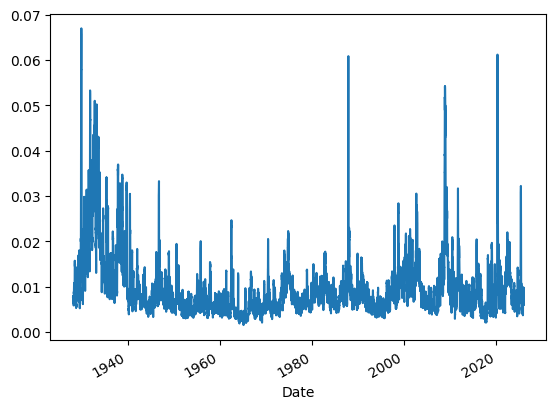

In [13]:
vol = rt.rolling(20).std()
vol.plot()

<Axes: xlabel='Date'>

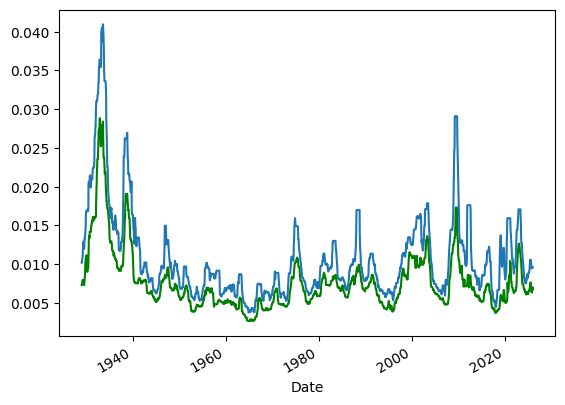

In [18]:
from numpy import quantile


low=vol.rolling(252).quantile(0.3)
high=vol.rolling(252).quantile(0.7)
low.plot(color='g')
high.plot()

# Time to stop and reflect

this rolling window based std quantile volatility regime dector is simple, but not stupid, it works, 

if you want to get more serious about this and build more complicated models, 
you optimise one of the following parameters:
1. Memory
2. Multi-scale behaviour
3. Joint behavior with returns/ liquidity
4. Probabilistic uncertainty 


# Multi scale behavior

essentially we're checking different time frames to validate our theories about what the current state of volatility can tell us. 

In [19]:
short_tf, med_tf,long_tf = 3,14,60

short_vol = rt.rolling(short_tf).std()
med_vol = rt.rolling(med_tf).std()
long_vol = rt.rolling(long_tf).std()


In [ ]:
# normalising vol
short_vol_norm = short_vol.rolling(window=252, min_periods=20).apply(
    lambda x: (x.iloc[-1] - x.mean()) / x.std() if x.std() != 0 else 0
)


In [34]:
from scipy.stats import norm
short_quantile = short_vol_norm.apply(lambda x: norm.cdf(x))

In [35]:
short_quantile

Date
1928-01-03 00:00:00-05:00         NaN
1928-01-04 00:00:00-05:00         NaN
1928-01-05 00:00:00-05:00         NaN
1928-01-06 00:00:00-05:00         NaN
1928-01-09 00:00:00-05:00         NaN
                               ...   
2025-12-17 00:00:00-05:00    0.360278
2025-12-18 00:00:00-05:00    0.553218
2025-12-19 00:00:00-05:00    0.632268
2025-12-22 00:00:00-05:00    0.192701
2025-12-23 00:00:00-05:00    0.251766
Name: Close, Length: 24611, dtype: float64

In [36]:
# now do that for med and long and test the following regimes:

Trade-allowed regimes (v1)
	•	med / med / med ✅
	•	med / med / low ✅

No-trade regimes (v1)
	•	low / low / low ❌
	•	high / low / low ❌
	•	low / med / med ❌ (default)